In [64]:
import argparse
import os

import dataloader
import model
import Myloss
import torch
import torch.optim
import matplotlib.pyplot as plt

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def train(config):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    scale_factor = config.scale_factor
    DCE_net = model.enhance_net_nopool(scale_factor).cuda()

    # DCE_net.apply(weights_init)
    if config.load_pretrain == True:
        DCE_net.load_state_dict(torch.load(config.pretrain_dir))
    train_dataset = dataloader.lowlight_loader(config.lowlight_images_path)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
    )

    L_color = Myloss.L_color()
    L_spa = Myloss.L_spa()
    L_exp = Myloss.L_exp(16)
    # L_exp = Myloss.L_exp(16,0.6)
    L_TV = Myloss.L_TV()

    optimizer = torch.optim.Adam(
        DCE_net.parameters(), lr=config.lr, weight_decay=config.weight_decay
    )

    DCE_net.train()
    history = []
    best_loss = 1
    for epoch in range(config.num_epochs):
        for iteration, img_lowlight in enumerate(train_loader):
            img_lowlight = img_lowlight.cuda()

            E = 0.6

            enhanced_image, A = DCE_net(img_lowlight)
            Loss_TV = 1600 * L_TV(A)
            # Loss_TV = 200*L_TV(A)
            loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))
            loss_col = 5 * torch.mean(L_color(enhanced_image))

            loss_exp = 10 * torch.mean(L_exp(enhanced_image, E))

            # best_loss
            loss = Loss_TV + loss_spa + loss_col + loss_exp

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(DCE_net.parameters(), config.grad_clip_norm)
            optimizer.step()
            
            if ((iteration + 1) % config.snapshot_iter) == 0:
                torch.save(
                    DCE_net.state_dict(), config.snapshots_folder + 'Epoch' + str(epoch) + '.pth'
                )
            if loss.item() < best_loss:
                torch.save(
                    DCE_net.state_dict(), config.snapshots_folder + 'best_model.pth'
                )
                best_loss = loss.item()
        history.append((epoch,loss.item()))
        print(f'Loss at Epoch {epoch}: {loss.item()}')
    x_values, y_values = zip(*history)
    
    plt.plot(x_values, y_values, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [65]:
class Config():
    lowlight_images_path = '/home/hiepdvh/low-light-recognition-trial/trainZeroDCE/'
    lr = 0.0001
    weight_decay=0.0001
    grad_clip_norm=0.1
    num_epochs=100
    train_batch_size=32
    val_batch_size=8
    num_workers=4
    display_iter=10
    snapshot_iter=12
    scale_factor=8
    snapshots_folder='/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/training-weight/'
    load_pretrain=False
    pretrain_dir='snapshots_Zero_DCE++/Epoch99.pth'

config = Config()


Total training examples: 436


/tmp/ipykernel_1544409/1432850182.py:69: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(DCE_net.parameters(), config.grad_clip_norm)


Loss at Epoch 0: 3.1684622764587402
Loss at Epoch 1: 3.070474624633789
Loss at Epoch 2: 3.1086223125457764
Loss at Epoch 3: 3.0662474632263184
Loss at Epoch 4: 2.94584059715271
Loss at Epoch 5: 2.9363393783569336
Loss at Epoch 6: 2.7838432788848877
Loss at Epoch 7: 2.6545512676239014
Loss at Epoch 8: 2.5352089405059814
Loss at Epoch 9: 2.5172600746154785
Loss at Epoch 10: 2.3139634132385254
Loss at Epoch 11: 2.1595728397369385
Loss at Epoch 12: 2.2988181114196777
Loss at Epoch 13: 1.802624225616455
Loss at Epoch 14: 1.4173468351364136
Loss at Epoch 15: 1.2714155912399292
Loss at Epoch 16: 1.4249236583709717
Loss at Epoch 17: 1.4708876609802246
Loss at Epoch 18: 1.4775395393371582
Loss at Epoch 19: 1.1549921035766602
Loss at Epoch 20: 1.3745638132095337
Loss at Epoch 21: 1.2192552089691162
Loss at Epoch 22: 1.3943501710891724
Loss at Epoch 23: 1.114323377609253
Loss at Epoch 24: 1.067375659942627
Loss at Epoch 25: 1.3678953647613525
Loss at Epoch 26: 1.3764156103134155
Loss at Epoch 27:

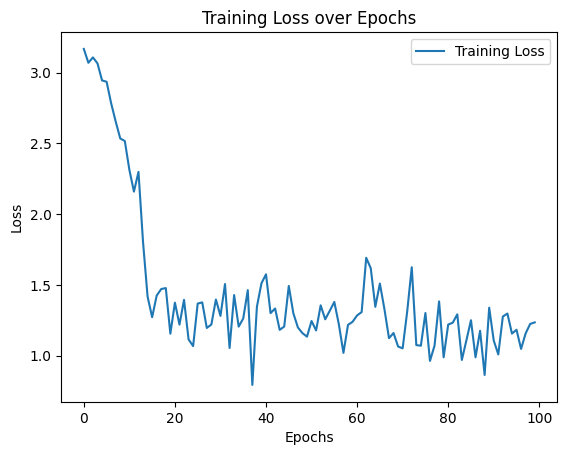

In [66]:
train(config)

In [67]:
import os
import time

import cv2
import model
import numpy as np
import torch
import torch.optim
import torchvision
from PIL import Image


def lowlight(data_lowlight, weight_path):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    scale_factor = 12

    data_lowlight = data_lowlight.convert('RGB')

    data_lowlight = np.asarray(data_lowlight) / 255.0

    data_lowlight = torch.from_numpy(data_lowlight).float()

    h = (data_lowlight.shape[0] // scale_factor) * scale_factor
    w = (data_lowlight.shape[1] // scale_factor) * scale_factor
    data_lowlight = data_lowlight[0:h, 0:w, :]
    data_lowlight = data_lowlight.permute(2, 0, 1)
    data_lowlight = data_lowlight.cuda().unsqueeze(0)

    DCE_net = model.enhance_net_nopool(scale_factor).cuda()
    DCE_net.load_state_dict(torch.load(weight_path))
    start = time.time()
    enhanced_image, params_maps = DCE_net(data_lowlight)

    end_time = time.time() - start

    return enhanced_image


def lowlight_frame(frame, weight_path):
    scale_factor = 12

    frame = frame / 255.0  # Chuẩn hóa frame từ [0, 255] thành [0, 1]

    # Chuyển frame thành tensor và thực hiện các bước xử lý
    frame = torch.from_numpy(frame).float().cuda()

    h = (frame.shape[0] // scale_factor) * scale_factor
    w = (frame.shape[1] // scale_factor) * scale_factor
    frame = frame[0:h, 0:w, :]
    frame = frame.permute(2, 0, 1)
    frame = frame.unsqueeze(0)
    DCE_net = model.enhance_net_nopool(scale_factor).cuda()
    DCE_net.load_state_dict(torch.load(weight_path))
    # Thực hiện xử lí bằng mô hình DCE_net
    enhanced_frame, params_maps = DCE_net(frame)

    enhanced_frame = (
        enhanced_frame[0].permute(1, 2, 0).cpu().numpy() * 255.0
    )  # Chuyển kết quả về [0, 255]

    return enhanced_frame



In [68]:
test_low_light_images = os.listdir(
        '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/test/low'
    )
weight_path = '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/training-weight/best_model.pth'
for low_light_image in test_low_light_images:
    low_light_image_path = os.path.join(
        '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/test/low',
        low_light_image,
    )
    original_image = Image.open(low_light_image_path)
    enhanced_image = lowlight(original_image, weight_path)
    result_path = os.path.join(
        '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/test/high_aftertrain',
        low_light_image,
    )
    torchvision.utils.save_image(enhanced_image, result_path)

In [69]:
import os

import cv2
import numpy as np
import torch
from lpips import LPIPS
from scipy.stats import entropy
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


def calculate_metrics(original_img, enhanced_img):
    # Chuyển đổi ảnh từ [0, 255] sang [0, 1]
    original_img = original_img.astype(np.float32) / 255.0
    enhanced_img = enhanced_img.astype(np.float32) / 255.0
    original_img.resize(enhanced_img.shape)
    # PSNR
    psnr_value = psnr(original_img, enhanced_img, data_range=1.0)

    # SSIM
    ssim_value, _ = ssim(original_img, enhanced_img, full=True, data_range=1.0)

    # Entropy
    entropy_original = entropy(original_img.flatten())
    entropy_enhanced = entropy(enhanced_img.flatten())

    # Standard Deviation
    std_dev_original = np.std(original_img)
    std_dev_enhanced = np.std(enhanced_img)
    original_tensor = torch.from_numpy(original_img)
    enhanced_tensor = torch.from_numpy(enhanced_img)
    lpips_value = lpips_model(original_tensor, enhanced_tensor).item()
    return (
        psnr_value,
        ssim_value,
        entropy_original,
        entropy_enhanced,
        std_dev_original,
        std_dev_enhanced,
        lpips_value,
    )

In [70]:
lpips_model = LPIPS(net='vgg')
original_image_folder = (
    '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/test/low'
)
enhanced_image_folder = (
    '/home/hiepdvh/low-light-recognition-trial/Zero-DCE++/test/high_aftertrain'
)

images = os.listdir(original_image_folder)
results = ''
average_psnr = 0
average_ssim = 0
average_entropy = 0
average_std = 0
average_lpips = 0
for i, image in enumerate(images):
    original_image_path = os.path.join(original_image_folder, image)
    enhanced_image_path = os.path.join(enhanced_image_folder, image)
    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    enhanced_img = cv2.imread(enhanced_image_path, cv2.IMREAD_GRAYSCALE)

    (
        psnr_value,
        ssim_value,
        entropy_original,
        entropy_enhanced,
        std_dev_original,
        std_dev_enhanced,
        lpips_value,
    ) = calculate_metrics(original_img, enhanced_img)
    result = f'{image}\npsnr: {psnr_value}, ssim: {ssim_value}, entropy: {entropy_enhanced}, std: {std_dev_enhanced}, lpips: {lpips_value}'
    results = results + result + '\n'
    average_psnr = (average_psnr*i + psnr_value)/(i+1)
    average_ssim = (average_ssim*i + ssim_value)/(i+1)
    average_entropy = (average_entropy*i + entropy_enhanced)/(i+1)
    average_std= (average_std*i + std_dev_enhanced)/(i+1)
    average_lpips = (average_lpips*i + lpips_value)/(i+1)

print(results)
print(f' average_psnr: {average_psnr} \n average_ssim: {average_ssim} \n average_entropy: {average_entropy} \n average_std: {average_std} \n average_lpips: {average_lpips}')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/hiepdvh/miniconda3/envs/livefaceidapp/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hiepdvh/miniconda3/envs/livefaceidapp/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/hiepdvh/miniconda3/envs/livefaceidapp/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth
ThanhDat_first_frame.jpg
psnr: 13.97468632312103, ssim: 0.2434920010397044, entropy: 13.440531730651855, std: 0.1454649716615677, lpips: 0.4731643497943878
HoangAnh_first_frame.jpg
psnr: 11.884749300531048, ssim: 0.25115214481948434, entropy: 12.288902282714844, std: 0.09035265445709229, lpips: 0.597171425819397
NgocQuang_first_frame.jpg
psnr: 9.858825469934203, ssim: 0.25578660392526614, entropy: 12.088143348693848, std: 0.21575191617012024, lpips: 0.5568220615386963
NguyenXuanNam_first_frame.jpg
psnr: 15.294005613267093, ssim: 0.24419765786706055, entropy: 13.723893165588379, std: 0.017228690907359123, lpips: 0.39114341139793396
DangHung_first_frame.jpg
psnr: 12.146869919619936, ssim: 0.26689013738119044, entropy: 12.897233963012695, std: 0.06830788403749466, lpips: 0.3674239218235016
MaiAnh_first_frame.jpg
psnr: 11.01821560398713, ssim: 0.3263398841282074, entropy: 